# Natural Adversarial Objects Detection using Swin Transformer

## Part 2 - Swin Transformer

-------------------------------------
To evaluate the robustness of these methods, researchers have developed the Natural Adversarial Object (NAO) dataset, which is designed to test the ability of object detectors to handle realistic and challenging real-world scenarios. It has been observed that the mean average precision (mAP) of some detection models drops significantly when evaluated on NAO compared to the standard MSCOCO validation set. In this tutorial, we will also experiment with the **Swin Transformer** as a backbone in **RetinaNet** how it performs on NAO dataset.

**Swin Transformer** is a variant of the popular transformer architecture, which has been widely used for natural language processing tasks. It employs a hierarchical architecture with a mix of patch-based and pixel-based processing to improve the representation of images at different scales. By leveraging the advantages of both patch-based and pixel-based processing, Swin Transformer is able to achieve high accuracy with fewer parameters than other transformer-based models. Swin Transformer has shown promise for a wide range of vision tasks, including image classification, object detection, and semantic segmentation.

<figure align="center">
    <p>
    <img style="width: 1500px" src='https://amaarora.github.io/images/swin-transformer.png' />
    </p>
    <figcaption>Overview architecture of Swin Transformer</figcaption>
</figure>

An overview of the Swin Transformer architecture is presented in the Figure above, which illustrates the tiny version (SwinT). It first splits an input RGB image into non-overlapping patches by a patch splitting module, like ViT. Each patch is treated as a “token” and its feature is set as a concatenation of the raw pixel RGB values. The patch size of 4 × 4 is used and thus the feature dimension of each patch is 4 × 4 × 3 = 48. A linear embedding layer is applied on this raw-valued feature to project it to an arbitrary dimension (denoted as C).

### 1. Set up

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 642.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0
    Uninstalling torchvision-0.13.0:
      Successfully uninstalled torchvision-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.9.0 requires torch>=1.10.0, but you have torch 1.9.0+cu111 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.

In [ ]:
from mmcv import collect_env
collect_env()

/opt/conda/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


{'sys.platform': 'linux',
 'Python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) [GCC 9.4.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 11.3, V11.3.109',
 'GCC': 'gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.28.1
11.1
GCC 7.3


### 2. Prepare dataset

Extract the `natural-adversarial-object.zip` that processed data in part 1.

*Note: we have provided the processed data in the tutorial folder, which you can use right away.*




Copy dataset or symlink the dataset root to `$MMDETECTION/data` as below.


    mmdetection
        ├── mmdet
        ├── tools
        ├── configs
        ├── data
        │   ├── coco
        │   │   ├── annotations
        │   │   ├── train
        │   │   ├── vallidation
        │   │   ├── test


In [ ]:
!mkdir -p data/coco/annotations

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!cp /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/annotations/instances_train.json data/coco/annotations
!cp /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/annotations/instances_validation.json data/coco/annotations/
!cp /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/annotations/instances_test.json data/coco/annotations/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!cp -r /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/images/train data/coco
!cp -r /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/images/validation data/coco
!cp -r /kaggle/input/natural-adversarial-objects/natural-adversarial-objects/images/test data/coco

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### 3. Training

Modify path `train`,`val` and `test` in dataset configuration file `configs/_base_/datasets/coco_detection.py`

In [ ]:
%%writefile configs/_base_/datasets/coco_detection.py

# dataset settings
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_train.json',
        img_prefix=data_root + 'train/',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_validation.json',
        img_prefix=data_root + 'validation/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_test.json',
        img_prefix=data_root + 'test/',
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='bbox')


Overwriting configs/_base_/datasets/coco_detection.py


### 3.1 Existed model configuration file

We will use the provided configuration file for swin transformer`retinanet_swin-t-p4-w7_fpn_1x_coco.py` in `mmdetection/configs/swin/`.

The settings in `retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py` are similar to those in the file above `retinanet_swin-t-p4-w7_fpn_1x_coco.py` , except 
- learning rate (0.01 -> 0.001)
- epochs (12 -> 24)

In [ ]:
%%writefile configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py
_base_ = [
    '../_base_/models/retinanet_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
]
pretrained = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth'  # noqa
model = dict(
    backbone=dict(
        _delete_=True,
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(1, 2, 3),
        # Please only add indices that would be used
        # in FPN, otherwise some parameter will not be used
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(type='Pretrained', checkpoint=pretrained)),
    neck=dict(in_channels=[192, 384, 768], start_level=0, num_outs=5))

runner = dict(type='EpochBasedRunner', max_epochs=24)

optimizer = dict(type='SGD', lr=0.001, momentum=0.9, weight_decay=0.0001)


Writing configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py


Run `tools/train.py` to launch training jobs

*Note: you can check out this [link documentation](https://mmdetection.readthedocs.io) for better understaning how to use script*

In [ ]:
!python tools/train.py \
    configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/opt/conda/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:49: UserWarning: Setti

After completing the training process, the results, including the checkpoints and logs, will be saved in the `mmdetection/work_dirs` directory

In [ ]:
!tree work_dirs

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
work_dirs
└── retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr
    ├── 20230217_055657.log
    ├── 20230217_055657.log.json
    ├── epoch_1.pth
    ├── epoch_10.pth
    ├── epoch_11.pth
    ├── epoch_12.pth
    ├── epoch_13.pth
    ├── epoch_14.pth
    ├── epoch_15.pth
    ├── epoch_16.pth
    ├── epoch_17.pth
    ├── epoch_18.pth
    ├── epoch_19.pth
    ├── epoch_2.pth
    ├── epoch_20.pth
    ├── epoch_21.pth
    ├── epoch_22.pth
    ├── epoch_23.pth
    ├── epoch_24.pth
    ├── epoch_3.pth
    ├── epoch_4.pth
    ├── epoch_5.pth
    ├── epoch_6.pth
    ├── epoch_7.pth
    ├── epoch_8.pth
    ├── epoch_9.pth
    ├── latest.pth -> epoch_24.pth
    └── retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py

1 directory, 28 files


Visualize log

In [ ]:
log_file = !(echo work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/*.json | cut -d " " -f1)

In [ ]:
log_file = log_file[-1]
log_file

'work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/20230217_055657.log.json'

In [ ]:
!python tools/analysis_tools/analyze_logs.py plot_curve \
        $log_file \
        --keys loss_cls loss_bbox \
        --legend loss_cls loos_bbox \
        --out work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/losses.pdf

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
plot curve of work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/20230217_055657.log.json, metric is loss_cls
plot curve of work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/20230217_055657.log.json, metric is loss_bbox
save curve to: work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/losses.pdf


In [ ]:
!python tools/analysis_tools/analyze_logs.py plot_curve \
        $log_file \
        --keys bbox_mAP \
        --legend bbox_mAP \
        --out work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/mAP.pdf

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
plot curve of work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/20230217_055657.log.json, metric is bbox_mAP
save curve to: work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/mAP.pdf


In [ ]:
from wand.image import Image as WImage

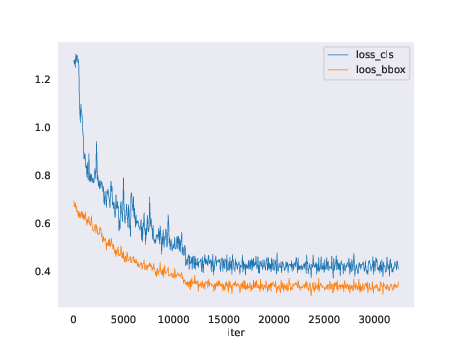

In [ ]:
img = WImage(filename='work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/losses.pdf')
img

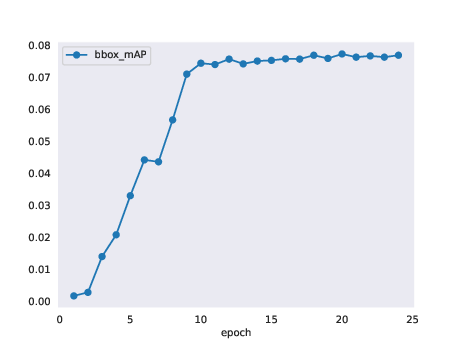

In [ ]:
img = WImage(filename='work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/mAP.pdf')
img

As you can see in the figure above, the bbox_mAP during evaluation after each epoch is very low

Evaluate model

In [ ]:
!python tools/test.py \
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py \
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/latest.pth \
    --eval bbox \
    --out work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results.pkl

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/opt/conda/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:49: UserWarning: Setti

Run inference on test set and extract images that have the highest and lowest topk scores after sorting, this will be saved in `work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results`
`
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results
    ├── bad          #top lowest
    └── good         #top highest
 `

Extract *50* images per folder in `work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results`

In [ ]:
!python tools/analysis_tools/analyze_results.py \
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr.py \
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results.pkl \
    work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results \
    --topk 50


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/opt/conda/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 367/367, 3.6 task/s, elapsed: 102s, ETA:     0s

In [ ]:
import os
import random
from IPython.display import display, Image

# function that display a random image in a directory
def display_random_image(directory_path):
    # Get a list of all image filenames in the directory
    image_filenames = [filename for filename in os.listdir(directory_path) if filename.endswith('.jpg') or filename.endswith('.png')]
    
    if len(image_filenames) == 0:
        print(f"No image files found in {directory_path}")
        return
    
    # Choose a random image filename from the list
    random_filename = random.choice(image_filenames)
    print(f'Display image {random_filename} with ground truth and prediction')
    
    # Display the image in the notebook
    image_path = os.path.join(directory_path, random_filename)
    display(Image(filename=image_path))

In `bad` folder

Display image 7ccafb823be060ec_0.0.jpg with ground truth and prediction


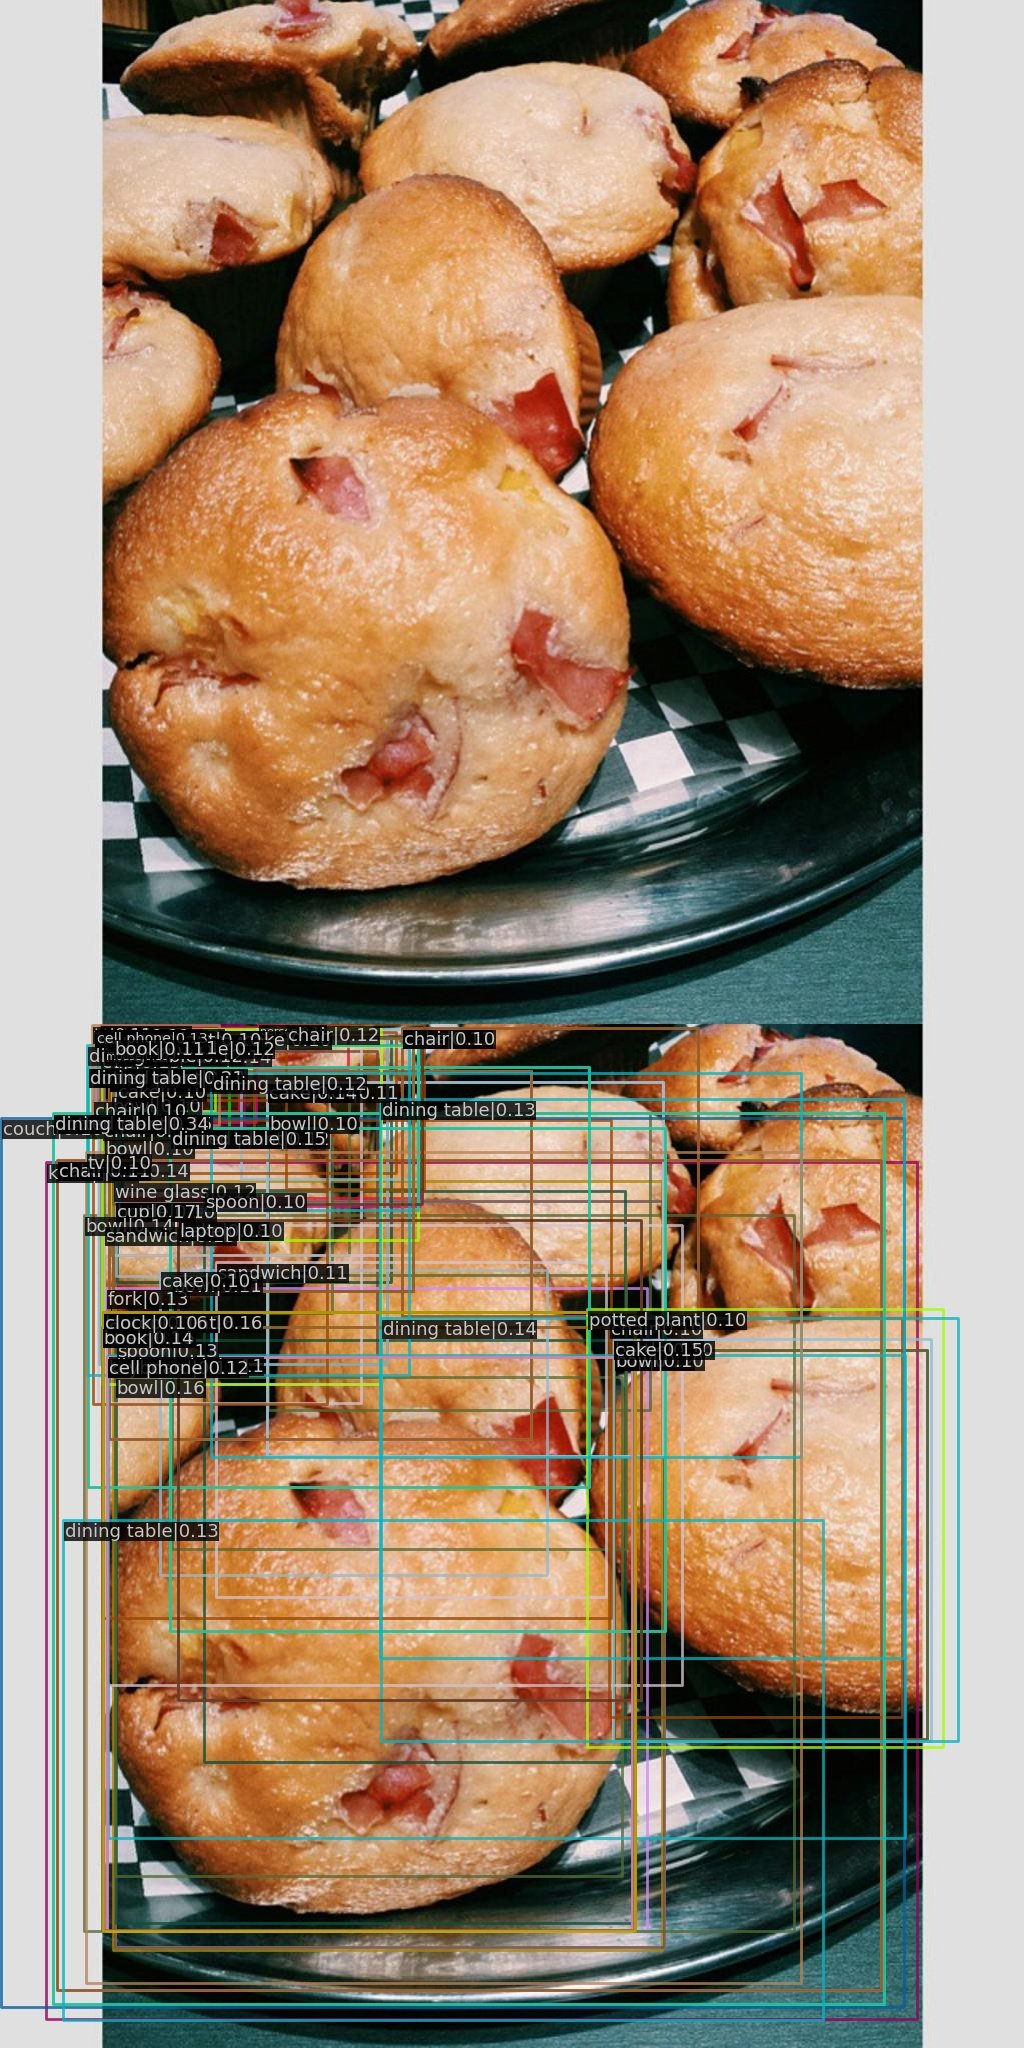

Display image 7d15e14d504a303f_0.0.jpg with ground truth and prediction


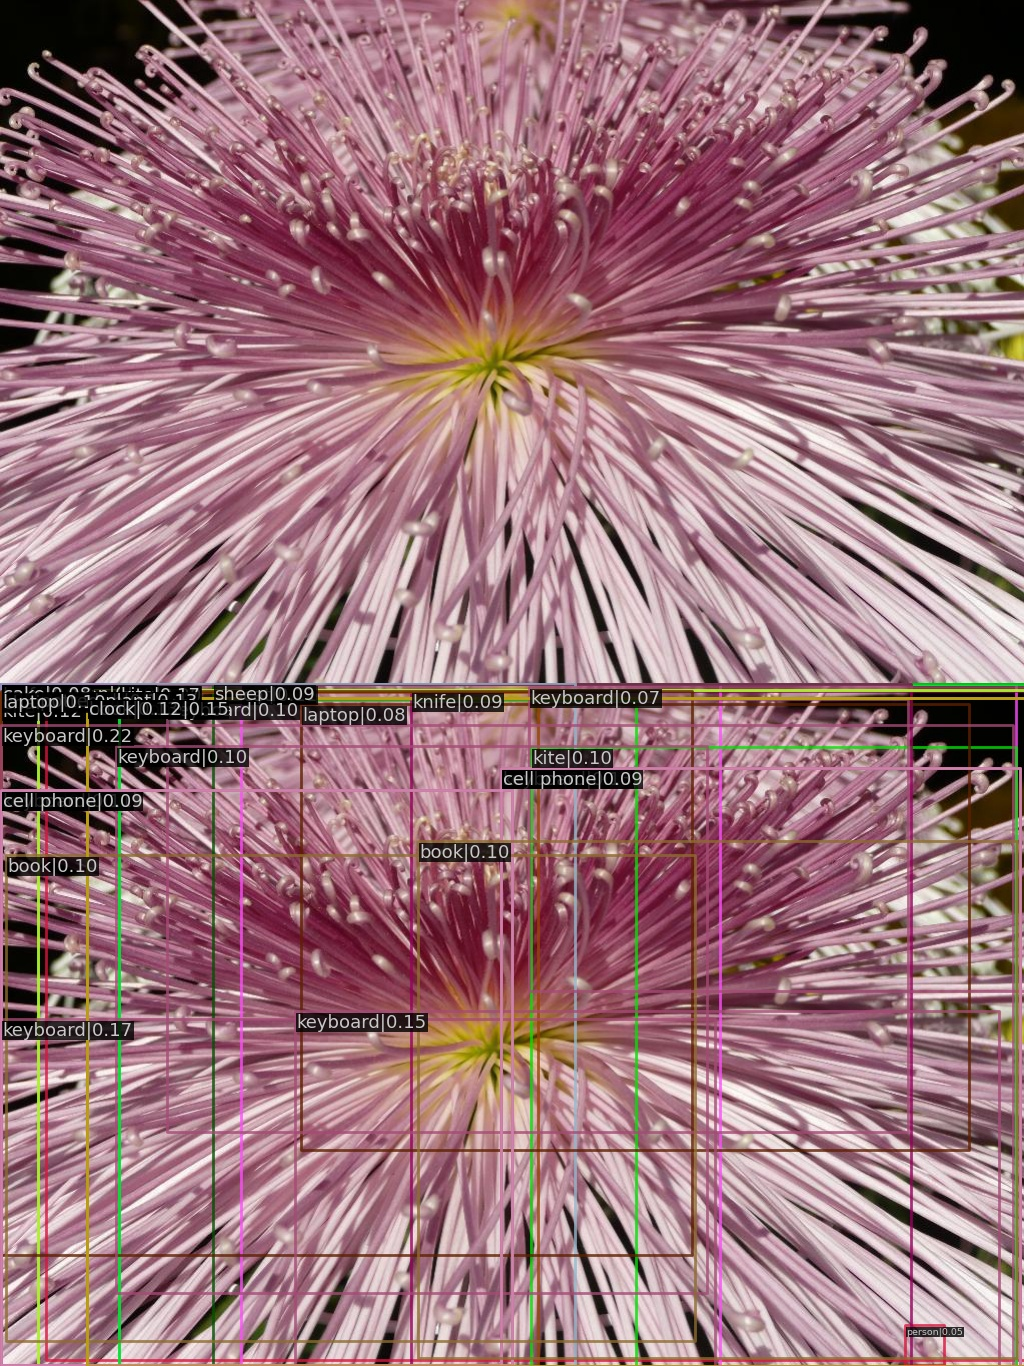

Display image 7ccafb823be060ec_0.0.jpg with ground truth and prediction


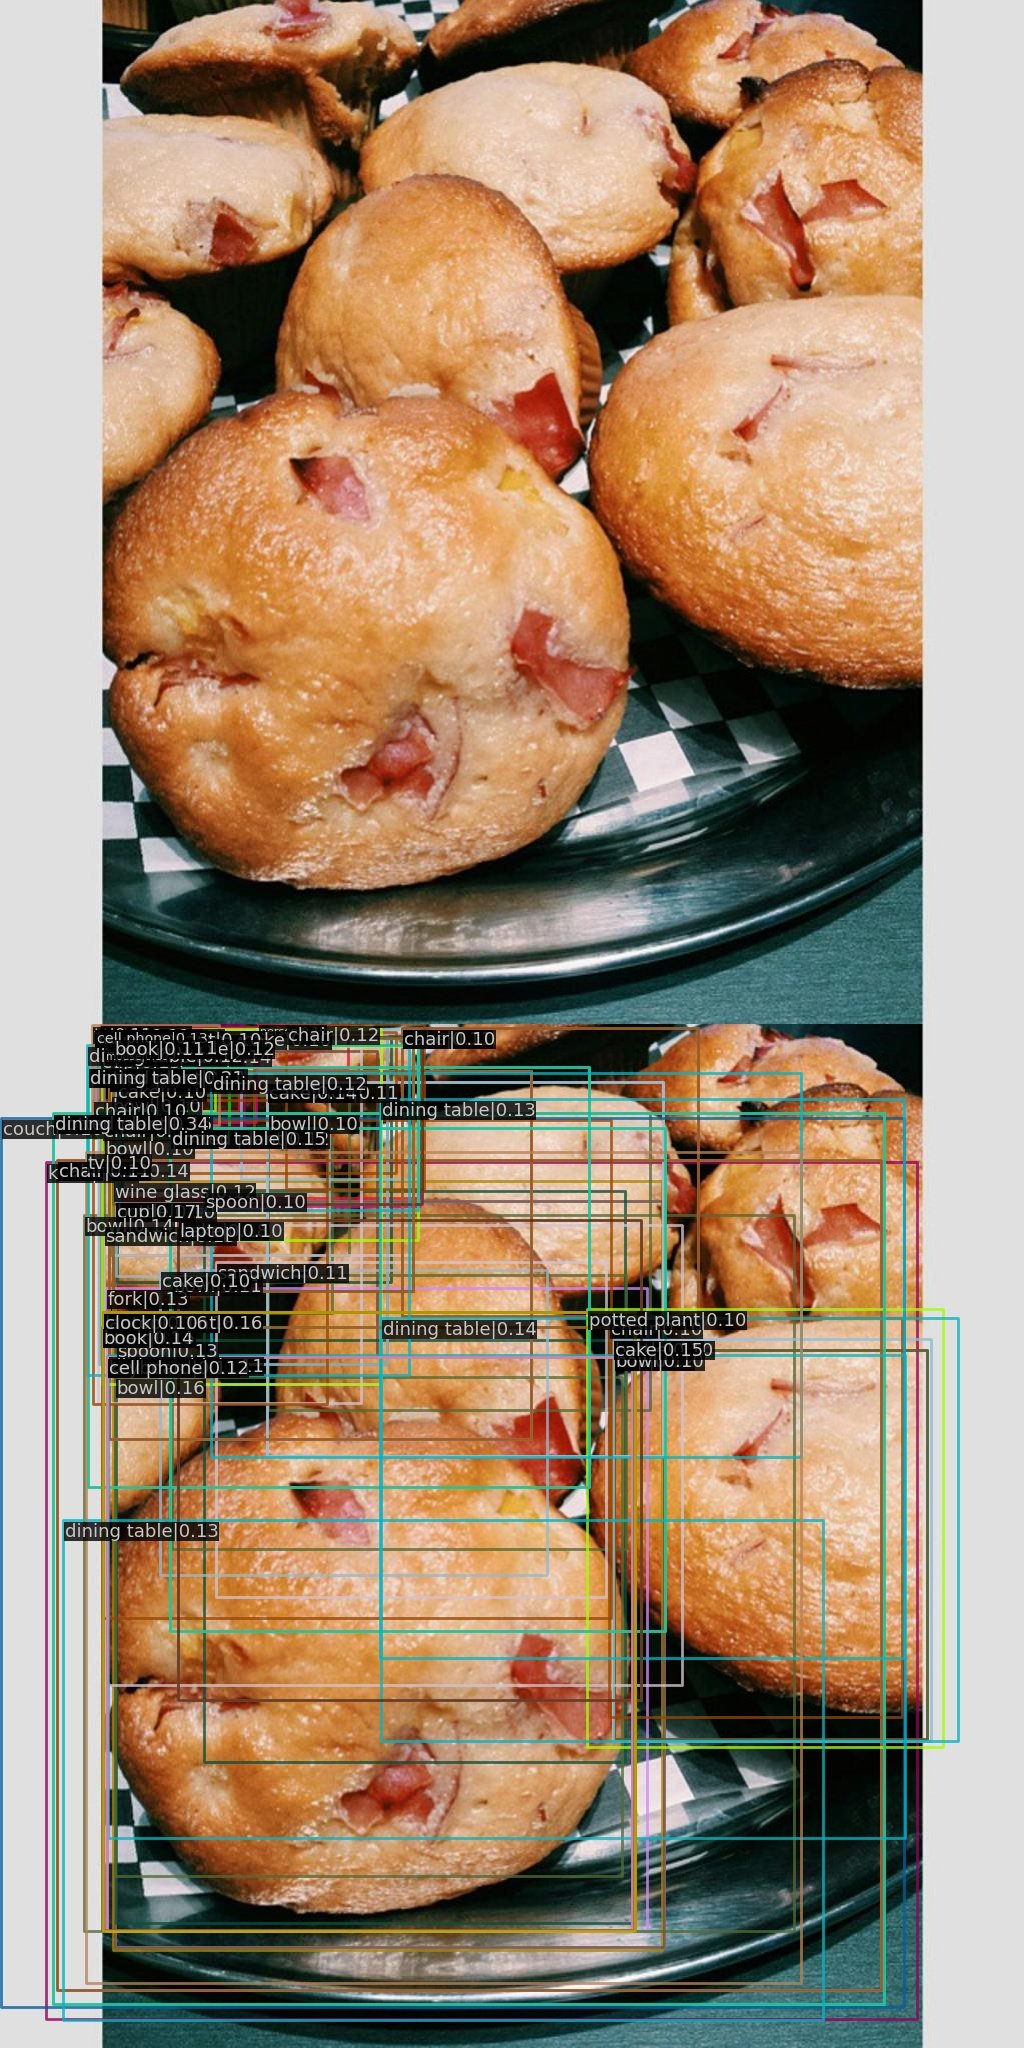

In [ ]:
for i in range(3):
    display_random_image('work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results/bad')

In `good` folder

Display image 843b644fe4471eb5_0.9.jpg with ground truth and prediction


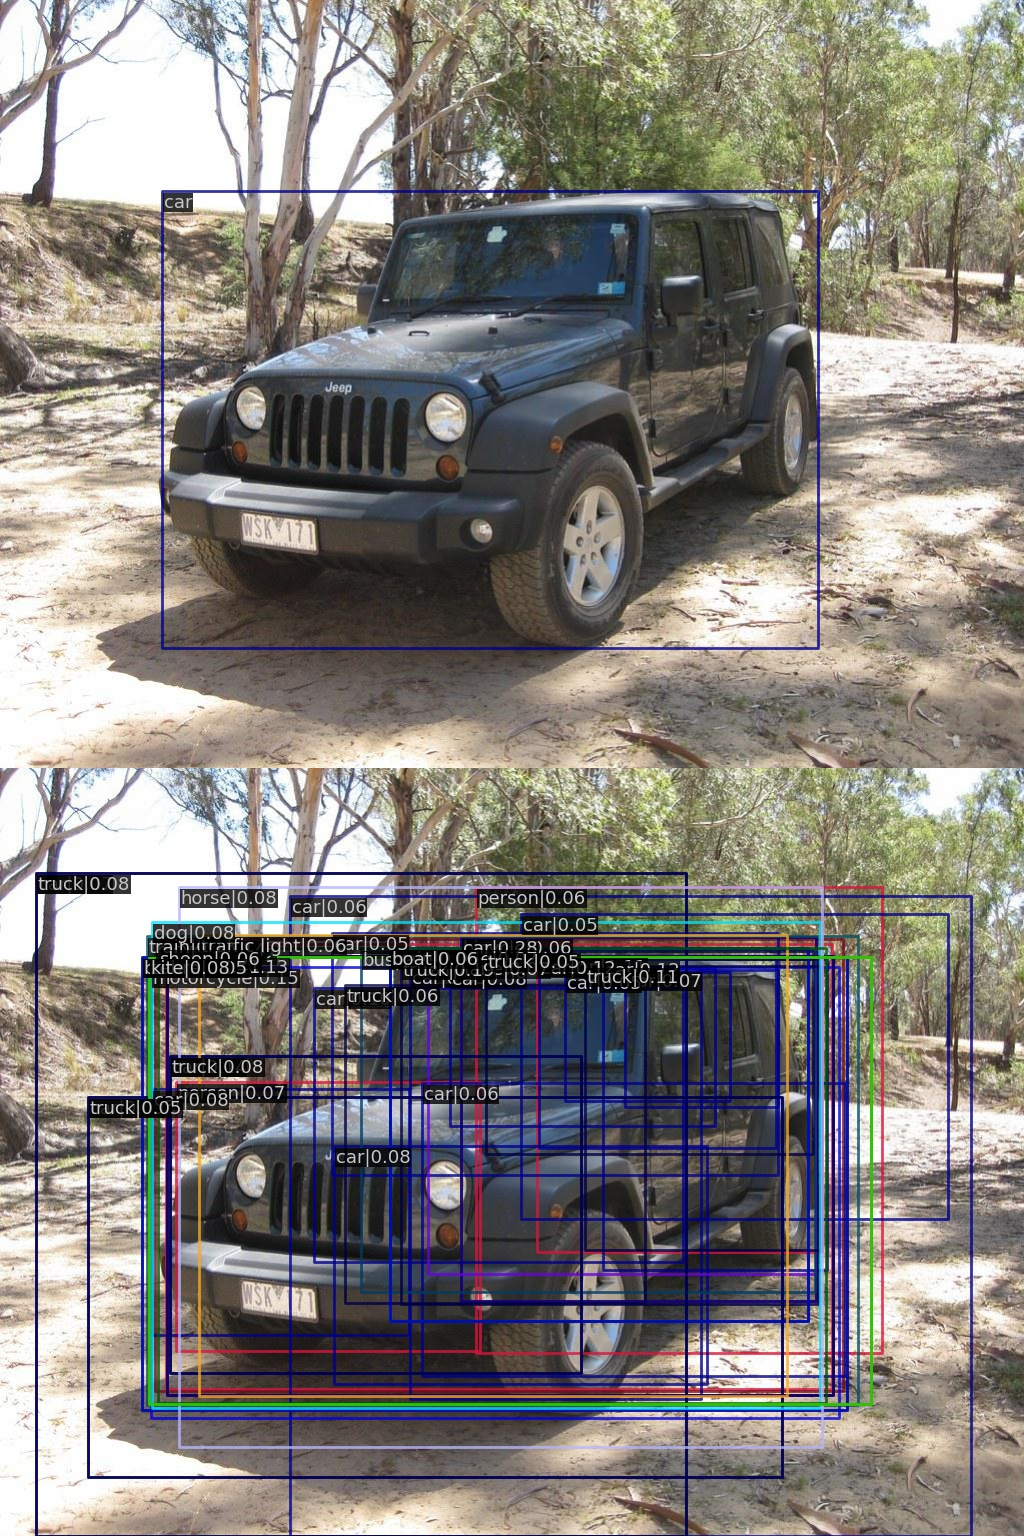

Display image 4d57b4c8b6af8528_0.487.jpg with ground truth and prediction


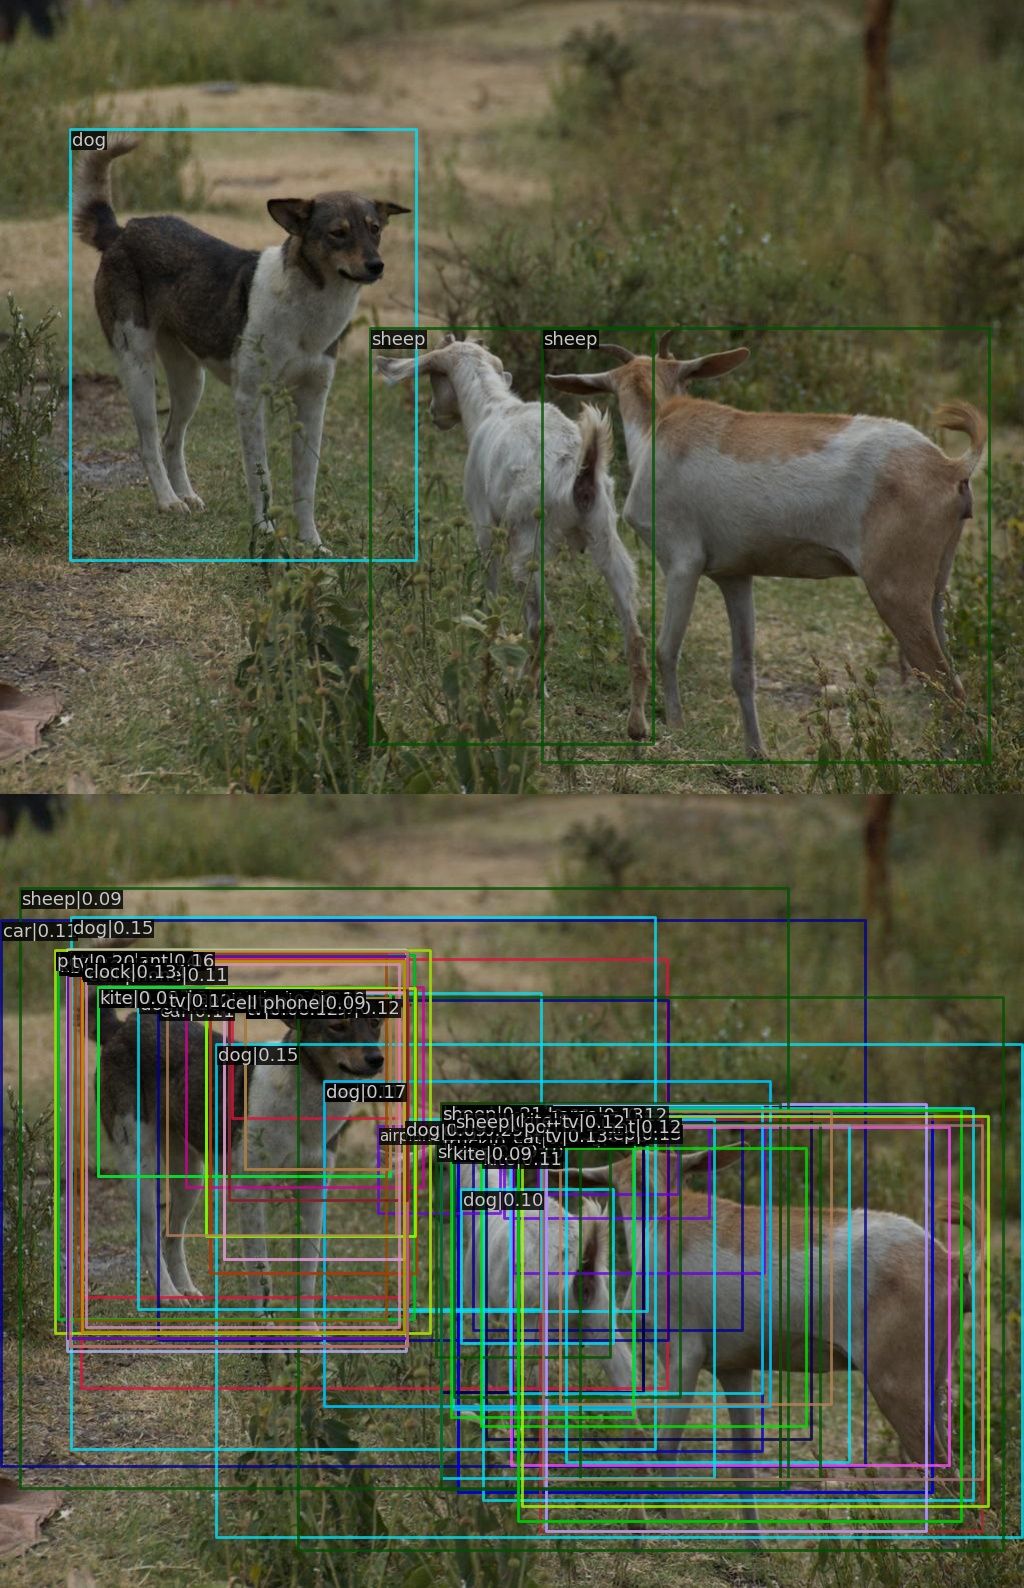

Display image 7bbc7526b886e592_0.444.jpg with ground truth and prediction


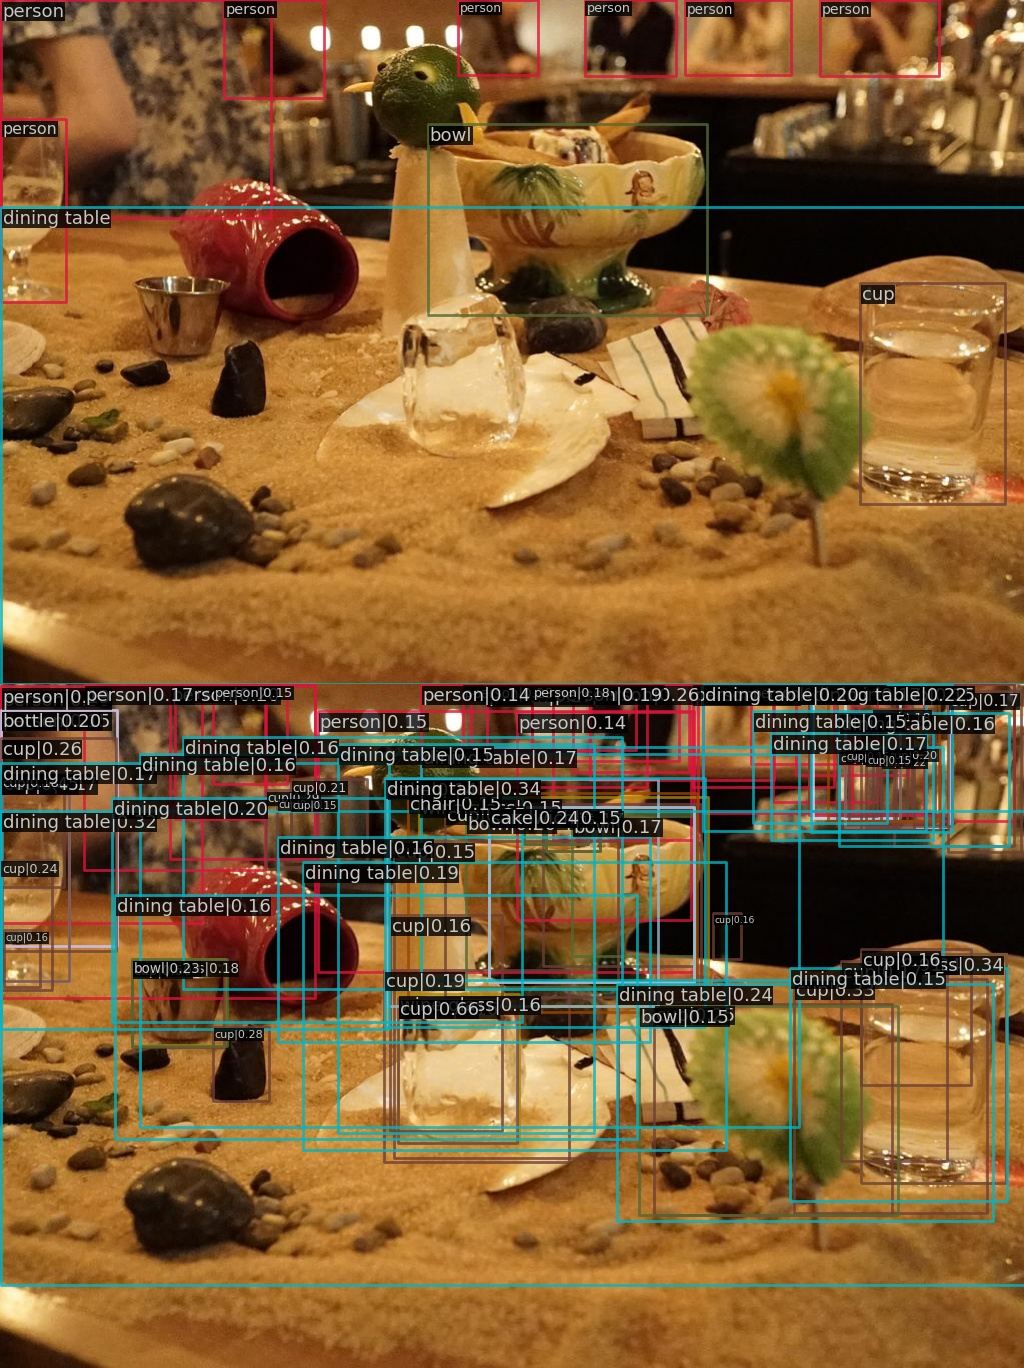

In [ ]:
for i in range(3):
    display_random_image('work_dirs/retinanet_swin-t-p4-w7_fpn_1x_coco_reduce_lr/results/good')

### 3.2 Customized model 

We can create our own customized model in addition to using the provided configuration files. Furthermore, we have experimented with using the Swin Transformer as the backbone in a one-stage detection model (**RetinaNet**), and now we are interested in exploring its performance when used as the backbone in a two-stage detection model (**Faster R-CNN**)

Define **Faster R-CNN** in `configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py`

Add configuration file for complete pipeline

In [ ]:
# %%writefile configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py

# _base_ = [
#     '../_base_/models/cascade_rcnn_r50_fpn.py',
#     '../_base_/datasets/coco_detection.py',
#     '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
# ]
# pretrained = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth'
# model = dict(
#     backbone=dict(
#         _delete_=True,
#         type='SwinTransformer',
#         embed_dims=96,
#         depths=[2, 2, 18, 2],
#         num_heads=[3, 6, 12, 24],
#         window_size=7,
#         mlp_ratio=4,
#         qkv_bias=True,
#         qk_scale=None,
#         drop_rate=0.,
#         attn_drop_rate=0.,
#         drop_path_rate=0.3,
#         patch_norm=True,
#         out_indices=(0, 1, 2, 3),
#         with_cp=False,
#         convert_weights=True,
#         init_cfg=dict(type='Pretrained', checkpoint=pretrained)),
#     neck=dict(in_channels=[96, 192, 384, 768]),
#     roi_head=dict(
#         type='CascadeRoIHead',
#         num_stages=3,
#         stage_loss_weights=[1, 0.5, 0.25],
#         bbox_roi_extractor=dict(
#             type='SingleRoIExtractor',
#             roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
#             out_channels=256,
#             featmap_strides=[4, 8, 16, 32]),
#         bbox_head=[
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.1, 0.1, 0.2, 0.2]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 reg_decoded_bbox=True,
#                 loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.05, 0.05, 0.1, 0.1]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 reg_decoded_bbox=True,
#                 loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
#             dict(
#                 type='Shared2FCBBoxHead',
#                 in_channels=256,
#                 fc_out_channels=1024,
#                 roi_feat_size=7,
#                 num_classes=80,
#                 bbox_coder=dict(
#                     type='DeltaXYWHBBoxCoder',
#                     target_means=[0., 0., 0., 0.],
#                     target_stds=[0.033, 0.033, 0.067, 0.067]),
#                 reg_class_agnostic=True,
#                 loss_cls=dict(
#                     type='CrossEntropyLoss',
#                     use_sigmoid=False,
#                     loss_weight=1.0),
#                 reg_decoded_bbox=True,
#                 loss_bbox=dict(type='GIoULoss', loss_weight=10.0))
#         ]))

# optimizer = dict(
#     _delete_=True,
#     type='AdamW',
#     lr=0.0004,
#     betas=(0.9, 0.999),
#     weight_decay=0.05,
#     paramwise_cfg=dict(
#         custom_keys={
#             'absolute_pos_embed': dict(decay_mult=0.),
#             'relative_position_bias_table': dict(decay_mult=0.),
#             'norm': dict(decay_mult=0.)
#         }))
# lr_config = dict(warmup_iters=500, step=[8, 11])
# runner = dict(max_epochs=24)


In [ ]:
# !python tools/train.py \
#     configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py

### 4. Conclusion
- This is because the NAO dataset contains objects that have been carefully crafted to deceive the detection models, such as sensitive textures that resemble other objects, or objects that have been fragmented or distorted in ways that are difficult for the models to recognize.
-  robustness cannot be simply achieved by training a more accurate model